In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import os
from time import time

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # 过滤掉 Tensorflow 的 Warning 信息

import tensorflow.examples.tutorials.mnist.input_data as input_data
import numpy as np
import matplotlib.pyplot as plt

### 1. 数据预处理

In [3]:
mnist = input_data.read_data_sets('data/', one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [4]:
print('train images shape:', mnist.train.images.shape)
print('train labels shape:', mnist.train.labels.shape)
print()
print('validation images shape:', mnist.validation.images.shape)
print('validation labels shape:', mnist.validation.labels.shape)
print()
print('test images shape:', mnist.test.images.shape)
print('test labels shape:', mnist.test.labels.shape)

train images shape: (55000, 784)
train labels shape: (55000, 10)

validation images shape: (5000, 784)
validation labels shape: (5000, 10)

test images shape: (10000, 784)
test labels shape: (10000, 10)


### 2. 建立共享函数

#### 2.1 定义 weight 函数, 用于建立权重张量

In [5]:
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='W')

#### 2.2 定义 bias 函数, 用于建立偏差张量

In [6]:
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape), name='b')

#### 2.3 定义 conv2d 函数, 用于进行卷积运算

In [7]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

#### 2.4 定义 max_pool_2x2 函数, 用于建立池化层

In [8]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### 3. 建立模型

#### 3.1 输入层

In [9]:
with tf.name_scope('Input_Layer'):
    x = tf.placeholder('float', shape=[None, 784], name='x')
    x_image = tf.reshape(x, [-1, 28, 28, 1])

#### 3.2 卷积层1

In [10]:
with tf.name_scope('C1_Conv'):
    W1 = weight([5, 5, 1, 16])
    b1 = bias([16])
    Conv1 = conv2d(x_image, W1) + b1
    C1_Conv = tf.nn.relu(Conv1)

In [11]:
with tf.name_scope('C1_Pool'):
    C1_Pool = max_pool_2x2(C1_Conv)

#### 3.3 卷积层2

In [12]:
with tf.name_scope('C2_Conv'):
    W2 = weight([5, 5, 16, 36])
    b2 = bias([36])
    Conv2 = conv2d(C1_Pool, W2) + b2
    C2_Conv = tf.nn.relu(Conv2)

In [13]:
with tf.name_scope('C2_Pool'):
    C2_Pool = max_pool_2x2(C2_Conv)

#### 3.4 全连接层

In [14]:
with tf.name_scope('D_Flat'):
    D_Flat = tf.reshape(C2_Pool, [-1, 1764])

In [15]:
with tf.name_scope('D_Hidden_Layer'):
    W3 = weight([1764, 128])
    b3 = bias([128])
    D_Hidden = tf.nn.relu(tf.matmul(D_Flat, W3) + b3)
    D_Hidden_Dropout = tf.nn.dropout(D_Hidden, keep_prob=0.8)

#### 3.5 输出层

In [16]:
with tf.name_scope('Output_Layer'):
    W4 = weight([128, 10])
    b4 = bias([10])
    y_predict = tf.nn.softmax(tf.matmul(D_Hidden_Dropout, W4) + b4)

### 4. 定义训练方式

#### 3.1 建立训练数据 label 真实值的 placeholder

In [17]:
with tf.name_scope('optimizer'):
    # 定义损失函数
    y_label = tf.placeholder('float', [None, 10], name='y_label')
    
    # 定义损失函数
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    
    # 定义优化器
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_function)

### 5. 定义评估模型准确率的方式

In [18]:
with tf.name_scope('evaluate_model'):
    correct_prediction = tf.equal(tf.argmax(y_label, axis=1), 
                                  tf.argmax(y_predict, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

### 6. 开始训练

In [19]:
train_epochs = 15
batch_size = 100
total_batch = int(mnist.train.num_examples / batch_size)
epoch_list = []
loss_list = []
acc_list = []

In [20]:
start_time = time()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(train_epochs):
    for i in range(total_batch):
        x_batch, y_batch = mnist.train.next_batch(batch_size=batch_size)
        sess.run(optimizer, feed_dict={x: x_batch, y_label: y_batch})
    
    loss, acc = sess.run([loss_function, accuracy], 
                         feed_dict={x: mnist.validation.images, y_label: mnist.validation.labels})
    epoch_list.append(epoch+1)
    loss_list.append(loss)
    acc_list.append(acc)
    print('train epoch:', '%02d' % (epoch + 1), 'loss:', '{:.9f}'.format(loss), 'acc:', acc)

print()
print('train finished. takes', time() - start_time, 'seconds')

train epoch: 01 loss: 1.667564631 acc: 0.8122
train epoch: 02 loss: 1.628974557 acc: 0.8394
train epoch: 03 loss: 1.615294456 acc: 0.8528
train epoch: 04 loss: 1.520540953 acc: 0.9522
train epoch: 05 loss: 1.505755424 acc: 0.961
train epoch: 06 loss: 1.498941064 acc: 0.9678
train epoch: 07 loss: 1.494952202 acc: 0.9696
train epoch: 08 loss: 1.493835688 acc: 0.9722
train epoch: 09 loss: 1.489154339 acc: 0.9734
train epoch: 10 loss: 1.488664269 acc: 0.9754
train epoch: 11 loss: 1.486197829 acc: 0.9776
train epoch: 12 loss: 1.484781146 acc: 0.9784
train epoch: 13 loss: 1.484792829 acc: 0.9784
train epoch: 14 loss: 1.483059764 acc: 0.9798
train epoch: 15 loss: 1.481593132 acc: 0.981

train finished. takes 788.1317231655121 seconds


### 7. 以图形显示训练过程

In [21]:
def show_train_history(x_values, y_values, title):
    plt.plot(x_values, y_values, label=title)
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend([title], loc='upper left')
    plt.show()

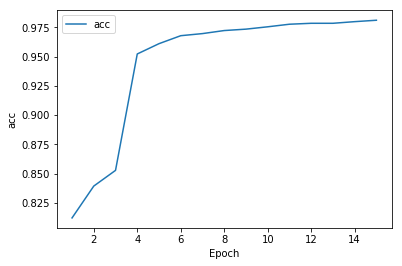

In [22]:
show_train_history(epoch_list, acc_list, 'acc')

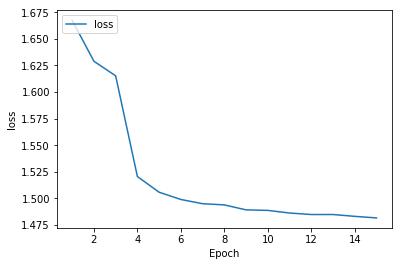

In [23]:
show_train_history(epoch_list, loss_list, 'loss')

### 8. 评估模型准确率

In [24]:
print('accuracy:', sess.run(accuracy, feed_dict={x: mnist.test.images, y_label: mnist.test.labels}))

accuracy: 0.9811


### 9. 进行预测

#### 9.1 执行预测

In [25]:
prediction_result = sess.run(tf.argmax(y_predict, axis=1), feed_dict={x: mnist.test.images})

#### 9.2 预测结果

In [26]:
prediction_result[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

#### 9.3 定义函数以显示10项预测结

In [27]:
def plot_images_labels_prediction(images, labels, predictions, idx, num=10):
    """
    images: 数字图像数组
    labels: 真实值数组
    predictions: 预测结果数据
    idx: 开始显示的数据index
    num: 要显示的数据项数, 默认为10, 不超过25
    """
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num > 25:
        num = 25
    for i in range(0, num):
        ax = plt.subplot(5, 5, i+1)
        ax.imshow(images[idx].reshape(28, 28), cmap='binary')
        title = 'lable=' + str(np.argmax(labels[idx]))
        if len(predictions) > 0:
            title += ',predict=' + str(predictions[idx])
        ax.set_title(title, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx += 1
    plt.show()

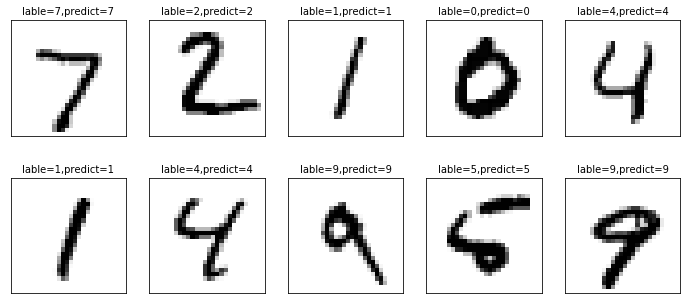

In [28]:
plot_images_labels_prediction(mnist.test.images, mnist.test.labels, prediction_result, 0, 10)

### 10. 找出预测错误

In [29]:
for i in range(300):
    label = np.argmax(mnist.test.labels[i])
    predict = prediction_result[i]
    if predict != label:
        print('i=' + str(i), 'label=' + str(label), 'predict=' + str(predict))

i=18 label=3 predict=8
i=151 label=9 predict=8
i=247 label=4 predict=6
i=290 label=8 predict=4


In [30]:
def show_images_labels_predict_error(images, labels, prediction_result):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    num = 0
    idx = 0
    while num < 10:
        label = np.argmax(mnist.test.labels[idx])
        predict = prediction_result[idx]
        if predict != label:
            ax = plt.subplot(5, 5, num+1)
            ax.imshow(np.reshape(images[idx], (28, 28)), cmap='binary')
            ax.set_title('idx:' + str(idx) + ',l:' + str(label) + ',p:' + str(predict), fontsize=9)
            num += 1
        idx += 1
    plt.show()

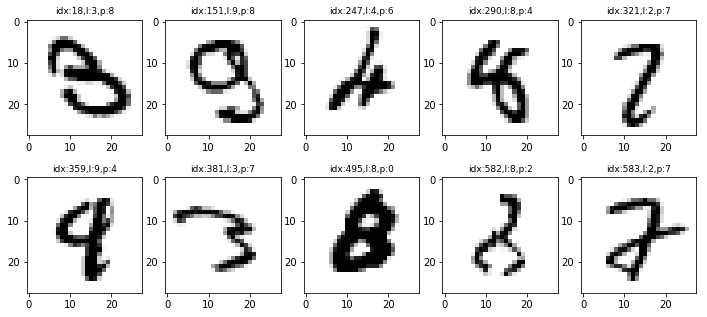

In [31]:
show_images_labels_predict_error(mnist.test.images, mnist.test.labels, prediction_result)

### 11. 保存模型

In [32]:
saver = tf.train.Saver()
save_path = saver.save(sess, 'save_model/tf/model_mnist_cnn_tf')
print('model saved in file: %s' % save_path)

model saved in file: save_model/tf/model_mnist_cnn_tf


### 12. 将计算图写入log文件, 用于在 TensorBoard 中查看

In [33]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('log/graph_mnist_cnn', sess.graph)

In [34]:
sess.close()